<a href="https://colab.research.google.com/github/kmchiti/AMP-Sequence-Generator/blob/main/LDPC_Energy_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Energy Model 

There is a lower bound energy of directly-implemented LDPC decoder circuits for a decoder with channel capacity $C$ and code rate $R$ as follow:
\begin{equation}
    \Omega\left(\chi^{2} \ln ^{3} \chi\right)
\end{equation}
Where $\chi=(1-R / C)^{-1}$.

Let's suppose that we have a faulty memory that the probability of flipping each bit is $P_0$. We can model the reading and writing on this memory as a Binary Symmetric Channel (BSC) with following properties:

* $N$: code length
* $k$: \# of information bit
* $P_\mathrm{obs}: \frac{\# \text { of errors }}{\text { code length }}$ where $\#$ of errors $\sim \operatorname{Binomial}\left(N, P_{0}\right)$
* $P_0$: The probability of filliping a bit
* $P^{*}$: The worst error rate that the ECC decoder can decode which depends on the code rate $\frac{k}{N}$ and must be chosen such that $\operatorname{Pr}\left(P_{\mathrm{obs}}>P^{*}\right) \leq \epsilon$ where $\epsilon$ must be very small. 

As we know, the capacity of BSC can be defined as follow:
\begin{equation}
    \begin{aligned}
C(P_0) &=\max _{p_{X}(x)} I(X ; Y) \\
&= 1 + P_0 \log(P_0) + (1-P_0) \log(1-P_0) 
\end{aligned}
\end{equation}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.stats import norm


In [ ]:
def channel_cap(p=0.01):
  #Input: P0
  #Output: C*
  c = 1 + p*np.log2(p) + (1-p)*np.log2(1-p)
  return (c)

In [ ]:
def energy_modeling(n=100, k=10, p=0.01):
  c = channel_cap(p)
  r = k/n
  x = 1/(1-(r/c))
  #print("C: ",c,"r: ", r,"X: ", x)
  res = ((x**2)*(np.log(x)**3))
  res[x<=0] = np.inf
  return res


In [ ]:
def memory_energy_modeling(n= 100, p=0.1, a = 0.9):
  e = (-np.log(p)/a) * n
  return (e)

In [ ]:
def invers_channel_cap(c = 0.3):
  f = lambda p : (1 + p*np.log2(p) + (1-p)*np.log2(1-p))-c
  x = np.arange(0.000001, 0.99999, 0.001)
  y = f(x)
  z = np.polyfit(x,y,2)
  init_guess1 = (-z[1]+(np.sqrt(z[1]**2 - 4*z[0]*z[2])))/(2*z[0])
  init_guess2 = (-z[1]-(np.sqrt(z[1]**2 - 4*z[0]*z[2])))/(2*z[0])
  #print(init_guess1, init_guess2)
  sol1 = fsolve(f,init_guess1)
  sol2 = fsolve(f,init_guess2)
  return sol1,sol2

In [ ]:
def CDF (k=30, N=100, p0=0.01):
  P_star = invers_channel_cap(k/N)
  #print("CodeRatio=",k/N)
  #print("P*=",P_star[1])
  x  = (P_star[1] - p0) / (np.sqrt(p0*(1-p0)/N))
  #print(x)
  return norm.cdf(x)

### Plot

In [ ]:
norm_LDPC_Enj = 30000 
norm_Mem_Enj = 10000
a = 0.9
LDPC_energy_unit = 3.6
Memory_energy_unit = 1
k = 32

def Enj_Total(N,p0):
  EnjMem = memory_energy_modeling(n=N, p=p0, a=a) * LDPC_energy_unit / norm_Mem_Enj
  EnjDec = energy_modeling(n=N, k=k, p=p0) * Memory_energy_unit / norm_LDPC_Enj
  #print("EnjMem:", EnjMem, "EnjDec", EnjDec)
  res = EnjMem+EnjDec
  res[res>0.5] = 0.5
  return res

In [ ]:
print(Enj_Total(np.ones(1)*100,np.ones(1)*0.04))
print(Enj_Total(np.ones(1)*74,np.ones(1)*0.1))


[0.12877154]
[0.07277588]


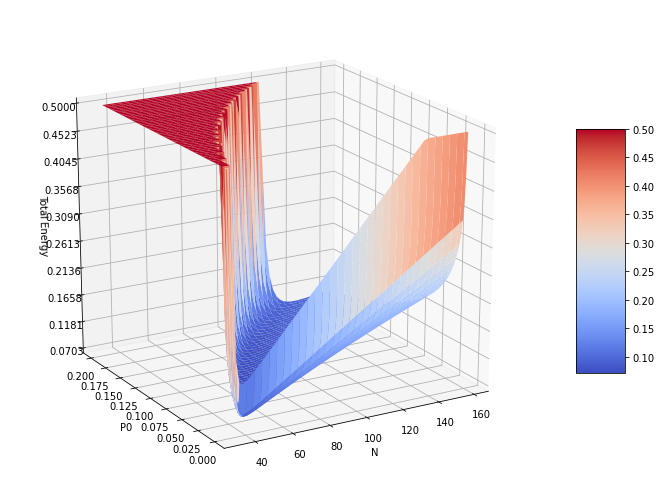

In [ ]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,9))

# Make data.
X = np.arange(k+1, k*5, 2)
Y = np.arange(0.0001, 0.2, 0.001)
X, Y = np.meshgrid(X, Y)
Z = Enj_Total(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0)

# Customize the z axis.
#ax.set_zlim(0, 3.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.set_xlabel("N")
ax.set_ylabel("P0")
ax.set_zlabel("Total Energy")

ax.view_init(elev=20., azim=240)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


Optimize result:
N: 59.93939393939394 p0: 0.0626949494949495 ENJ: 0.07034624657416874


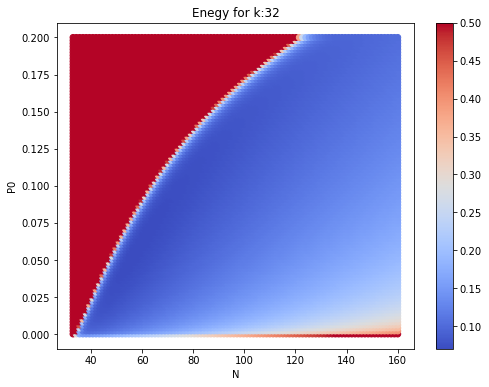

In [ ]:

from matplotlib import cm
from matplotlib.ticker import LinearLocator

k=32

X = np.linspace(k+1, k*5, 100)
Y = np.linspace(0.0001, 0.2, 100)
X, Y = np.meshgrid(X, Y)
Z = Enj_Total(X, Y)

fig = plt.figure(figsize=(8,6))
plt.scatter(X,Y,c=Z,cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("N")
plt.ylabel("P0")
plt.title("Enegy for k:"+str(k))

best_N = X[np.unravel_index(Z.argmin(), Z.shape)]
best_p = Y[np.unravel_index(Z.argmin(), Z.shape)]
best_Enj = Z[np.unravel_index(Z.argmin(), Z.shape)]
print("Optimize result:")
print("N:", best_N, "p0:", best_p, "ENJ:", best_Enj)




## MY Bayesian Optimization

In [ ]:
! pip install GPy gpyopt xgboost

In [ ]:
import GPy
import GPyOpt
from xgboost import XGBRegressor
from GPyOpt.methods import BayesianOptimization
import time

### BO

In [ ]:
# our imports for today
import numpy as np
import GPy
from scipy import stats
from scipy import optimize
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt


def expected_improvement_min(f, y_current, x_proposed):
    mu, var = f(x_proposed)
    std = var ** 0.5
    delta = y_current - mu

    # x / inf = 0
    std[std == 0] = np.inf
    z = delta / std
    unit_norm = stats.norm()
    return delta * unit_norm.cdf(z) + std * unit_norm.pdf(z)

def select_hyperparams_random(param_ranges):
    selection = {}
    for k in param_ranges:
        val = np.random.choice(np.linspace(*param_ranges[k]["range"], num=100))

        dtype = param_ranges[k]["type"]
        if dtype is "int":
            val = int(val)
        selection[k] = val
    return selection

class BayesOpt:
    def __init__(
        self, param_ranges, f, random_trials=5, optimization_trials=20, kernel=None, minimize=False
    ):
        self.param_ranges = param_ranges
        self.f = f
        self.random_trials = random_trials
        self.optimization_trials = optimization_trials
        self.n_trials = random_trials + optimization_trials
        self.x = np.zeros((self.n_trials, len(param_ranges)))
        self.y = np.zeros((self.n_trials, 1))
        self.best_y = np.zeros((self.n_trials, 1))
        self.minimize = minimize

        if kernel is None:
            self.kernel = GPy.kern.RBF(
                input_dim=self.x.shape[1], variance=1, lengthscale=1
            )
        else:
            self.kernel = kernel
        self.gp = None
        self.bounds = np.array([pr["range"] for pr in param_ranges.values()])

    @property
    def best_params(self):
        """
        Select best parameters.

        Returns
        -------
        best_parameters : dict
        """
        if(self.minimize):
          return self._prepare_kwargs(self.x[self.y.argmin()])
        else:
          return self._prepare_kwargs(self.x[self.y.argmax()])

    def fit(self):
        self._random_search()
        self._bayesian_search()

    def _random_search(self):
        """
        Run the random trials budget
        """
        print(f"Starting {self.random_trials} random trials...")
        for i in tqdm(range(self.random_trials)):
            hp = select_hyperparams_random(self.param_ranges)
            self.x[i] = np.array(list(hp.values()))
            self.y[i] = self.f(hp)

    def _bayesian_search(self):
        """
        Run the Bayesian Optimization budget
        """
        print(f"Starting {self.optimization_trials} optimization trials...")
        for i in tqdm(
            range(self.random_trials, self.random_trials + self.optimization_trials)
        ):
            self.x[i], self.y[i] = self._single_iter()
            if (self.minimize):
              #print(self.y[:].min())
              self.best_y[i] = self.y.min()
            else:
              self.best_y[i] = self.y[:].max()

    def _single_iter(self):
        """
        Fit a GP and retrieve and evaluate a new
        parameter proposal.

        Returns
        -------
        out : tuple[np.array[flt], np.array[flt]]
            (x, f(x))

        """
        self._fit_gp()
        x = self._new_proposal()
        y = self.f(self._prepare_kwargs(x))
        return x, y

    def _fit_gp(self, noise_var=0):
        """
        Fit a GP on the currently observed data points.

        Parameters
        ----------
        noise_var : flt
            GPY argmument noise_var
        """
        mask = self.x.sum(axis=1) != 0
        self.gp = GPy.models.GPRegression(
            self.x[mask],
            self.y[mask],
            normalizer=True,
            kernel=self.kernel,
            noise_var=noise_var,
        )
        self.gp.optimize()

    def _new_proposal(self, n=40):
        """
        Get a new parameter proposal by maximizing
        the acquisition function.

        Parameters
        ----------
        n : int
            Number of retries.
            Each new retry the optimization is
            started in another parameter location.
            This improves the chance of finding a global optimum.

        Returns
        -------
        proposal : dict
            Example:
           {'foo': 4.213, 'bar': 935}
        """

        def f(x):
            if (self.minimize):
              return -expected_improvement_min(
                  f=self.gp.predict, y_current=self.y.min(), x_proposed=x[None, :])
            else:
              return -expected_improvement(
                  f=self.gp.predict, y_current=self.y.max(), x_proposed=x[None, :])

        

        x0 = np.random.uniform(
            low=self.bounds[:, 0], high=self.bounds[:, 1], size=(n, self.x.shape[1])
        )
        proposal = None
        best_ei = np.inf
        for x0_ in x0:
            res = optimize.minimize(f, x0_, bounds=self.bounds)
            if res.success and res.fun < best_ei:
                best_ei = res.fun
                proposal = res.x
            if np.isnan(res.fun):
                raise ValueError("NaN within bounds")
        return proposal

    def plot_convergence(self, logg = False):

      best_y = np.zeros(self.y.shape)
      for i in range(len(best_y)):
        if(i==0):
          best_y[0] = self.y[0]
        else:
          best_y[i] = self.y[:i].min()


      plt.figure(figsize=(6,6))
      if (logg):
        print(np.exp(evaluate_params(bo.best_params)))
        plt.plot(np.arange(len(best_y)), np.exp(best_y), '-o')
      else:
        print(evaluate_params(bo.best_params))
        plt.plot(np.arange(len(best_y)), best_y, '-o')
      plt.title('Value of the best selected sample')
      plt.xlabel('Iteration')
      plt.ylabel('Best y')
      plt.grid(True)

    def plot_Mean_and_Var(self):
      kernel = GPy.kern.Matern52(2,ARD=True) + GPy.kern.White(2)
      model = GPy.models.GPRegression(self.x, self.y, kernel) 
      model.optimize()

      X = np.linspace(k+1, k*5, 100)
      Y = np.linspace(0.0001, 0.2, 100)
      x_test = []
      for i in X:
        for j in Y:
          x_test.append([i,j])
      x_test = np.array(x_test)

      Z_mu, Z_var = model.predict(x_test)
      h = plt.figure(figsize=(14,5))
      plt.subplot(121)
      plt.scatter(x_test[:,0], x_test[:,1], c=Z_mu, cmap=cm.coolwarm)
      plt.colorbar()
      plt.xlabel("N")
      plt.ylabel("P0")
      plt.title("Mean for k:"+str(k))
      plt.subplot(122)
      plt.scatter(x_test[:,0], x_test[:,1], c=Z_var, cmap=cm.coolwarm)
      plt.colorbar()
      plt.xlabel("N")
      plt.ylabel("P0")
      plt.title("Var for k:"+str(k))

    def _prepare_kwargs(self, x):
        """
        Create a dictionary with named parameters
        and the proper python types.

        Parameters
        ----------
        x : np.array
            Example:
            [4.213, 935.03]

        Returns
        -------
        hyperparameters : dict

            Example:
            {'foo': 4.213, 'bar': 935}
        """
        # create hyper parameter dict
        hp = dict(zip(self.param_ranges.keys(), x))
        # cast values
        for k in self.param_ranges:
            if self.param_ranges[k]["type"] == "int":
                hp[k] = int(hp[k])
            elif self.param_ranges[k]["type"] == "float":
                hp[k] = float(hp[k])
            else:
                raise ValueError("Parameter type not known")
        return hp

    

### My BO Result

In [ ]:

k = 32

def evaluate_params(hyperparams):
  N, p0 = hyperparams['N'], hyperparams['p0']
  res = Enj_Total(np.array([N]), np.array([p0]))
  print(hyperparams, res)
  return res

param_ranges = {
    'N': {
        'range': [33, 128],
        'type': 'int'
    },
    'p0': {
        'range': [0.0001, 0.2],
        'type': 'float'
    }
}

In [ ]:
bo = BayesOpt(param_ranges, evaluate_params, random_trials=10, optimization_trials=30,minimize=True)
bo.fit()

Starting 10 random trials...


100%|██████████| 10/10 [00:00<00:00, 769.84it/s]


{'N': 59, 'p0': 0.08288686868686869} [0.1528601]
{'N': 41, 'p0': 0.17778888888888889} [0.5]
{'N': 114, 'p0': 0.008176767676767676} [0.21917765]
{'N': 83, 'p0': 0.14144343434343434} [0.23232397]
{'N': 76, 'p0': 0.19798080808080806} [0.5]
{'N': 75, 'p0': 0.08490606060606061} [0.07509203]
{'N': 93, 'p0': 0.17173131313131312} [0.5]
{'N': 120, 'p0': 0.12327070707070707} [0.10060218]
{'N': 49, 'p0': 0.06471414141414142} [0.5]
{'N': 39, 'p0': 0.016253535353535353} [0.20589857]
Starting 30 optimization trials...


  3%|▎         | 1/30 [00:01<00:46,  1.62s/it]

{'N': 74, 'p0': 0.003172091882196528} [0.17032201]


  7%|▋         | 2/30 [00:02<00:33,  1.21s/it]

{'N': 118, 'p0': 0.0394681485664717} [0.15256965]


 10%|█         | 3/30 [00:03<00:32,  1.20s/it]

{'N': 121, 'p0': 0.0001} [0.44578227]


 13%|█▎        | 4/30 [00:04<00:29,  1.14s/it]

{'N': 57, 'p0': 0.058286300350843534} [0.07073526]


 17%|█▋        | 5/30 [00:05<00:25,  1.03s/it]

{'N': 56, 'p0': 0.2} [0.5]


 20%|██        | 6/30 [00:06<00:24,  1.02s/it]

{'N': 37, 'p0': 0.10583619593764806} [0.5]


 23%|██▎       | 7/30 [00:07<00:22,  1.02it/s]

{'N': 58, 'p0': 0.2} [0.5]


 27%|██▋       | 8/30 [00:08<00:22,  1.02s/it]

{'N': 59, 'p0': 0.0001} [0.21744084]


 30%|███       | 9/30 [00:09<00:20,  1.02it/s]

{'N': 112, 'p0': 0.10511526887958555} [0.10100997]


 33%|███▎      | 10/30 [00:10<00:20,  1.02s/it]

{'N': 111, 'p0': 0.0001} [0.40894172]


 37%|███▋      | 11/30 [00:11<00:19,  1.01s/it]

{'N': 81, 'p0': 0.15409814060840188} [0.5]


 40%|████      | 12/30 [00:12<00:17,  1.04it/s]

{'N': 57, 'p0': 9.999999999998899e-05} [0.21009381]


 43%|████▎     | 13/30 [00:13<00:16,  1.03it/s]

{'N': 55, 'p0': 0.2} [0.5]


 47%|████▋     | 14/30 [00:14<00:14,  1.07it/s]

{'N': 87, 'p0': 0.13358206541807616} [0.08012447]


 50%|█████     | 15/30 [00:15<00:15,  1.00s/it]

{'N': 86, 'p0': 0.12517063761801703} [0.07626893]


 53%|█████▎    | 16/30 [00:16<00:14,  1.04s/it]

{'N': 84, 'p0': 0.0001} [0.3094771]


 57%|█████▋    | 17/30 [00:17<00:13,  1.05s/it]

{'N': 112, 'p0': 0.2} [0.5]


 60%|██████    | 18/30 [00:18<00:12,  1.05s/it]

{'N': 88, 'p0': 0.0001} [0.32421164]


 63%|██████▎   | 19/30 [00:19<00:11,  1.06s/it]

{'N': 114, 'p0': 0.0001} [0.41999384]


 67%|██████▋   | 20/30 [00:20<00:09,  1.04it/s]

{'N': 59, 'p0': 0.0001} [0.21744084]


 70%|███████   | 21/30 [00:21<00:08,  1.03it/s]

{'N': 60, 'p0': 0.2} [0.5]


 73%|███████▎  | 22/30 [00:22<00:07,  1.09it/s]

{'N': 101, 'p0': 0.01039958429724129} [0.18447191]


 77%|███████▋  | 23/30 [00:23<00:06,  1.00it/s]

{'N': 111, 'p0': 0.0001} [0.40894172]


 80%|████████  | 24/30 [00:24<00:06,  1.09s/it]

{'N': 110, 'p0': 0.2} [0.5]


 83%|████████▎ | 25/30 [00:25<00:05,  1.07s/it]

{'N': 126, 'p0': 0.1016196048336392} [0.11527632]


 87%|████████▋ | 26/30 [00:26<00:04,  1.07s/it]

{'N': 127, 'p0': 0.05669004175453465} [0.14581196]


 90%|█████████ | 27/30 [00:27<00:03,  1.03s/it]

{'N': 57, 'p0': 0.0001} [0.21009381]


 93%|█████████▎| 28/30 [00:28<00:02,  1.04s/it]

{'N': 125, 'p0': 0.16869615218471104} [0.09021619]


 97%|█████████▋| 29/30 [00:29<00:01,  1.01s/it]

{'N': 124, 'p0': 0.2} [0.19719888]


100%|██████████| 30/30 [00:30<00:00,  1.03s/it]

{'N': 59, 'p0': 0.2} [0.5]


{'N': 57, 'p0': 0.058286300350843534} [0.07073526]
[0.07073526]


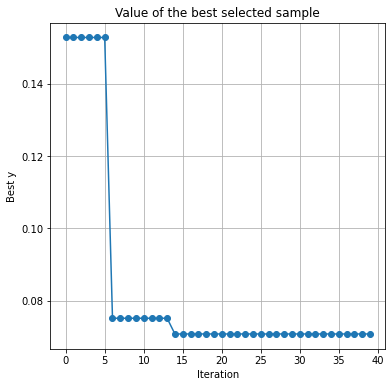

In [ ]:
bo.plot_convergence(logg=False)

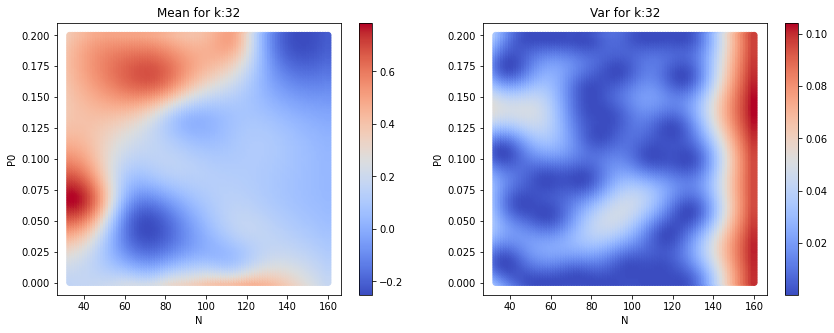

In [ ]:
bo.plot_Mean_and_Var()

## GD

In [ ]:
import torch

In [ ]:
def channel_cap(p=0.01):
  return 1 + p*torch.log2(p) + (1-p)*torch.log2(1-p)

def energy_modeling(n=100, k=10, p=0.01):
  c = channel_cap(p)
  r = k/n
  x = 1/(1-(r/c))
  res = ((x**2)*(torch.log(x)**3))
  res[x<=0] = 1e10
  return res

def memory_energy_modeling(n= 100, p=0.1, a = 0.9):
  e = (-torch.log(p)/a) * n
  return (e)

In [ ]:
norm_LDPC_Enj = 30000 
norm_Mem_Enj = 10000
a = 0.9
LDPC_energy_unit = 3.6
Memory_energy_unit = 1
k = 32

def Enj_Total(N,p0):
  EnjMem = memory_energy_modeling(n=N, p=p0, a=a) * LDPC_energy_unit / norm_Mem_Enj
  EnjDec = energy_modeling(n=N, k=k, p=p0) * Memory_energy_unit / norm_LDPC_Enj
  #print("EnjMem:", EnjMem, "EnjDec", EnjDec)
  res = EnjMem+EnjDec
  res[res>10] = 10
  return res

In [ ]:
N = torch.tensor([128.]).requires_grad_(True)
p0 = torch.tensor([0.17]).requires_grad_(True)
y = Enj_Total(N, p0)
torch.autograd.grad([y], [N, p0])

(tensor([0.0006]), tensor([-0.2210]))

In [ ]:
N = torch.tensor([94.]).requires_grad_(True)
p0 = torch.tensor([0.1]).requires_grad_(True)
for i in range(10000):
  y = Enj_Total(N, p0)
  if i % 100 == 0:
    print(N, p0, y)
  gs = torch.autograd.grad([y], [N, p0])
  N.data = N.data - 1e-3*gs[0]
  p0.data = p0.data - 1e-3*gs[1]
  #print(gs)

tensor([94.], requires_grad=True) tensor([0.1000], requires_grad=True) tensor([0.0869], grad_fn=<IndexPutBackward>)
tensor([94.], requires_grad=True) tensor([0.1274], requires_grad=True) tensor([0.0791], grad_fn=<IndexPutBackward>)
tensor([94.], requires_grad=True) tensor([0.1344], requires_grad=True) tensor([0.0784], grad_fn=<IndexPutBackward>)
tensor([94.], requires_grad=True) tensor([0.1347], requires_grad=True) tensor([0.0784], grad_fn=<IndexPutBackward>)
tensor([94.], requires_grad=True) tensor([0.1347], requires_grad=True) tensor([0.0784], grad_fn=<IndexPutBackward>)
tensor([94.], requires_grad=True) tensor([0.1347], requires_grad=True) tensor([0.0784], grad_fn=<IndexPutBackward>)
tensor([94.], requires_grad=True) tensor([0.1347], requires_grad=True) tensor([0.0784], grad_fn=<IndexPutBackward>)
tensor([94.], requires_grad=True) tensor([0.1347], requires_grad=True) tensor([0.0784], grad_fn=<IndexPutBackward>)
tensor([94.], requires_grad=True) tensor([0.1347], requires_grad=True) t

## BlackBox (DIRECT)

In [ ]:
!pip install scipydirect

     |████████████████████████████████| 49 kB 2.4 MB/s 
  Created wheel for scipydirect: filename=scipydirect-1.3-cp37-cp37m-linux_x86_64.whl size=119889 sha256=f8ad10dc056f27c4560b8b3c793a9ac574086539f5b4203287fbb18cfd0c2bc9
  Stored in directory: /root/.cache/pip/wheels/0a/37/f8/94f5bcddf560bef722ee993caafd8c53f123f69f16ca04a8cc
Successfully built scipydirect


In [ ]:
norm_LDPC_Enj = 30000 
norm_Mem_Enj = 10000
a = 0.9
LDPC_energy_unit = 3.2
Memory_energy_unit = 1
k=32
N = 60
def Enj_Total(p0):
  EnjMem = memory_energy_modeling(n=N, p=p0, a=a) * LDPC_energy_unit / norm_Mem_Enj
  EnjDec = energy_modeling(n=N, k=k, p=p0) * Memory_energy_unit / norm_LDPC_Enj
  res = EnjMem+EnjDec
  if(res>0.1): res = 0.1
  #print(N, p0, res)
  return res

In [ ]:
from scipydirect import minimize

bounds = np.array([[0.0001, 0.2]])
res = minimize(func=Enj_Total, bounds=bounds, maxT=50000)
print(res)

       x: array([0.06219079])
     fun: 0.06295931713326025
  status: 1
 success: True
 message: 'Number of function evaluations done is larger then maxf'
